Calculating correlation functions...
Calculation complete.


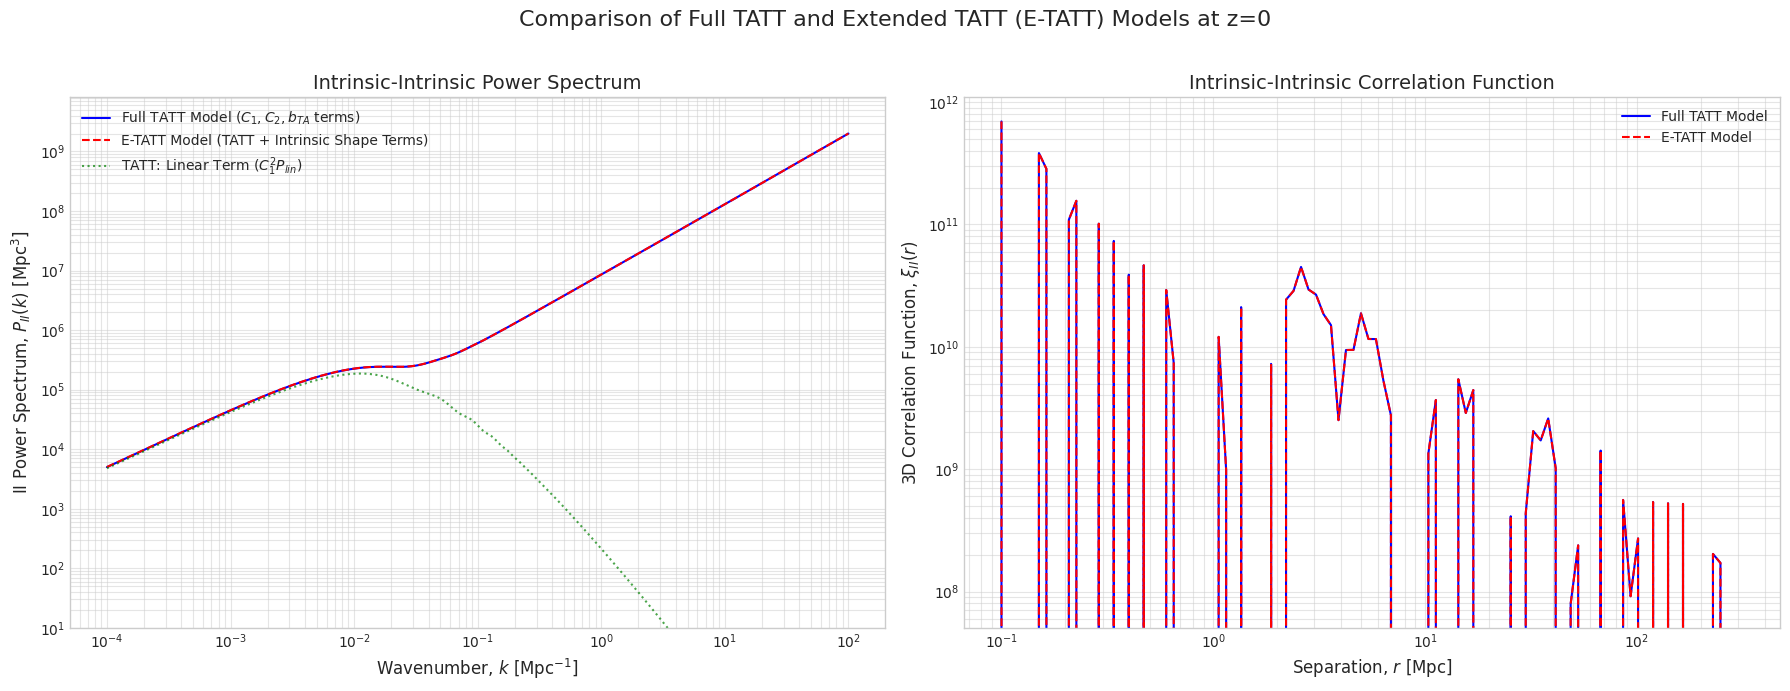

In [1]:
#
# A more complete Python script to calculate and compare intrinsic alignment
# power spectra and correlation functions for the TATT and E-TATT models.
#
# This version includes schematic representations of the quadratic and
# density-weighting terms in the standard TATT model.
#
# Required libraries:
# pip install numpy scipy matplotlib pyccl
#

import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simps

# ----------------------------------------------------------------------------
# 1. Define Cosmological and Model Parameters
# ----------------------------------------------------------------------------

# Set up a standard flat Lambda-CDM cosmology using pyccl
cosmo = ccl.Cosmology(
    Omega_c=0.27,
    Omega_b=0.045,
    h=0.67,
    A_s=2.1e-9,
    n_s=0.96,
)

# --- Define Intrinsic Alignment Model Parameters (at z=0) ---

# Standard TATT model parameters:
C1 = 1.5      # Linear alignment amplitude
C2 = 1.0      # Quadratic (tidal torquing) amplitude
b_TA = 0.8    # Density-weighting bias parameter

# E-TATT model parameters related to the stochastic inertia tensor:
# sigma_I_sq: The variance of the stochastic, intrinsic component of the
#             galaxy's shape (inertia tensor).
sigma_I_sq = 0.1**2

# C_int: The amplitude parameter that describes how the intrinsic shape
#        itself contributes to the observed shear (a shape noise term).
C_int = 1.0

# C_cross: The amplitude parameter for the new torque term, describing how
#          efficiently the tidal field torques the intrinsic shape component.
C_cross = 1.0

# sigma_s_sq: The variance of the tidal shear field.
sigma_s_sq = 0.5

# ----------------------------------------------------------------------------
# 2. Define Helper Functions
# ----------------------------------------------------------------------------

def power_spectrum_to_correlation(k, pk, r_vals):
    """
    Calculates the 3D two-point correlation function xi(r) from a
    power spectrum P(k) via a Hankel transform.
    """
    xi = np.zeros_like(r_vals)
    for i, r in enumerate(r_vals):
        integrand = k**2 * pk * np.sinc(k * r / np.pi)
        xi[i] = simps(integrand, k) / (2 * np.pi**2)
    return xi

def one_loop_power_spectrum_template(k, amplitude, power_law_index=1.5):
    """
    A template function to model the shape of one-loop power spectrum terms.
    This is an approximation to the full calculation from perturbation theory.
    We model it as a power law to capture its different scale dependence.
    """
    return amplitude * (k / k[0])**power_law_index

# ----------------------------------------------------------------------------
# 3. Perform the Main Calculation
# ----------------------------------------------------------------------------

# Define the range of wavenumbers (k) and radii (r) for our calculations.
k_vals = np.logspace(-4, 2, 512)
r_vals = np.logspace(-1, 2.5, 100)

# Get the linear matter power spectrum P_delta_delta(k) at z=0 from pyccl.
P_lin_matter = ccl.linear_matter_power(cosmo, k_vals, a=1.0)

# --- Calculate the Intrinsic-Intrinsic (II) Power Spectra ---

# --- Standard TATT model (more complete representation) ---
# P_II(k) = C1^2 * P_lin(k) + [higher order terms]
# The linear term
P_II_tatt_linear = C1**2 * P_lin_matter

# The quadratic and density-weighted terms (approximated with templates)
# The amplitudes are chosen for illustrative purposes.
P_II_tatt_quadratic = C2**2 * one_loop_power_spectrum_template(k_vals, amplitude=1e2, power_law_index=1.0)
P_II_tatt_density = 2 * C1 * b_TA * one_loop_power_spectrum_template(k_vals, amplitude=5e1, power_law_index=1.2)

# Total TATT power spectrum
P_II_tatt_total = P_II_tatt_linear + P_II_tatt_quadratic + P_II_tatt_density

# --- Extended E-TATT model ---
# The E-TATT model adds the new terms on top of the full TATT baseline.
# P_noise = (C_int^2 + C_cross^2 * sigma_s^2) * sigma_I^2
P_noise_from_intrinsic = (C_int**2 + C_cross**2 * sigma_s_sq) * sigma_I_sq

# The new scale-dependent term from the torque on the intrinsic shape.
# This term scales with the linear matter power spectrum.
P_new_torque_term = (C_cross**2 * sigma_I_sq) * P_lin_matter

# Total E-TATT power spectrum
P_II_etatt_total = P_II_tatt_total + P_noise_from_intrinsic + P_new_torque_term


# --- Calculate the 3D Two-Point Correlation Functions ---

print("Calculating correlation functions...")
xi_tatt = power_spectrum_to_correlation(k_vals, P_II_tatt_total, r_vals)
xi_etatt = power_spectrum_to_correlation(k_vals, P_II_etatt_total, r_vals)
print("Calculation complete.")

# ----------------------------------------------------------------------------
# 4. Plot the Results
# ----------------------------------------------------------------------------

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparison of Full TATT and Extended TATT (E-TATT) Models at z=0', fontsize=16)

# --- Plot 1: Power Spectra ---
ax1.loglog(k_vals, P_II_tatt_total, 'b-', label='Full TATT Model ($C_1, C_2, b_{TA}$ terms)')
ax1.loglog(k_vals, P_II_etatt_total, 'r--', label='E-TATT Model (TATT + Intrinsic Shape Terms)')
ax1.loglog(k_vals, P_II_tatt_linear, 'g:', alpha=0.7, label='TATT: Linear Term ($C_1^2 P_{lin}$)')
ax1.set_xlabel('Wavenumber, $k$ [Mpc$^{-1}$]', fontsize=12)
ax1.set_ylabel('II Power Spectrum, $P_{II}(k)$ [Mpc$^3$]', fontsize=12)
ax1.set_title('Intrinsic-Intrinsic Power Spectrum', fontsize=14)
ax1.legend()
ax1.set_ylim(bottom=1e1) # Adjust ylim to better see the features
ax1.grid(True, which="both", ls="-", alpha=0.5)

# --- Plot 2: Correlation Functions ---
ax2.loglog(r_vals, xi_tatt, 'b-', label='Full TATT Model')
ax2.loglog(r_vals, xi_etatt, 'r--', label='E-TATT Model')
ax2.set_xlabel('Separation, $r$ [Mpc]', fontsize=12)
ax2.set_ylabel('3D Correlation Function, $\\xi_{II}(r)$', fontsize=12)
ax2.set_title('Intrinsic-Intrinsic Correlation Function', fontsize=14)
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()